# Training, Evaluating and Comparing Models

In this notebook, different model architectures will be trained on the main data
as well as on the integrated data. All models will be evaluated, and finally
compared to another to select the best performing one.

Here, the train, val and test data is just loaded from files.
The data analysis and preparation was done in the notebook
`01-data_preparation.ipynb`.

# FIXME Todos
- if there is enough time, use further methods for evaluation of model
performance such as some sort of equivalent of AUROC but for regression

## Preparations

In [1]:
# dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from functools import partial

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error

# paths
PATH_DATA_MAIN = Path("../data/processed/main/")
PATH_DATA_INTEGRATED = Path("../data/processed/integrated/")
PATH_MODELS = Path("../models/")

In [2]:
# load data

# train data
X_train = pd.read_csv(PATH_DATA_MAIN / "sleep_data_main_train_features.csv")
y_train = pd.read_csv(PATH_DATA_MAIN / "sleep_data_main_train_labels.csv")

# test data
X_test = pd.read_csv(PATH_DATA_MAIN / "sleep_data_main_test_features.csv")
y_test = pd.read_csv(PATH_DATA_MAIN / "sleep_data_main_test_labels.csv")

# train data for integrated data set
X_train_integrated = pd.read_csv(
    PATH_DATA_INTEGRATED / "sleep_data_integrated_train_features.csv"
)
y_train_integrated = pd.read_csv(
    PATH_DATA_INTEGRATED / "sleep_data_integrated_train_labels.csv"
)

# test data for integrated data set
X_test_integrated = pd.read_csv(
    PATH_DATA_INTEGRATED / "sleep_data_integrated_test_features.csv"
)
y_test_integrated = pd.read_csv(
    PATH_DATA_INTEGRATED / "sleep_data_integrated_test_labels.csv"
)

# no validation data used, because models are tuned using cross validation

In [3]:
# define function to train model with grid search
def train_model_with_gridsearch(row, X_train, y_train):
    """
    Train model using GridSearchCV and return best results.
    
    Parameters:
    -----------
    row: pd.Series
        A row from the data frame containing the model and its parameter grid.
    
    Returns:
    --------
    pd.Series
        A series with the best parameters, best RMSE and best model.
    """
    
    # setup grid search
    grid_search = GridSearchCV(
        estimator=row['model'],
        param_grid=row['param_grid'],
        scoring='neg_root_mean_squared_error',  # sklearn uses negative RMSE
        cv=5,                                   # 5-fold cross-validation
        n_jobs=-1,                              # use all cores
        verbose=1
    )
    
    # fit grid search
    grid_search.fit(X_train, y_train.squeeze())
    
    # get best results and convert back to positive RMSE
    best_rmse = -grid_search.best_score_
    # get std of best model
    rmse_std = grid_search.cv_results_['std_test_score'][grid_search.best_index_]
    
    return pd.Series({
        'best_params': grid_search.best_params_,
        'best_rmse': round(best_rmse, 4),
        'rmse_std': round(rmse_std, 4),
        'best_model': grid_search.best_estimator_
    })

In [4]:
# function for comparing model performance
def calculate_differences_rmse(model_1, model_2, rmse_1, rmse_2):
    """
    Calculate the absolute and percentage difference of RMSE between two models.
    
    Parameters:
    -----------
    model_1: str
        Name of the first model.
    model_2: str
        Name of the second model.
    rmse_1: float
        RMSE of the first model.
    rmse_2: float
        RMSE of the second model.
        
    Returns:
    --------
    None, but prints the absolute and percentage difference.
    """
    
    # calculate absolute difference
    absolute_difference = round(abs(rmse_1 - rmse_2), 4)

    # calculate percentage difference
    percentage_difference = round((absolute_difference / rmse_1) * 100, 4)

    print(f"Model 1: {model_1} - Model 2: {model_2}")
    print(f"Absolute difference: {absolute_difference}")
    print(f"Percentage difference: {percentage_difference}%")
    print("\n")

## Hyperparameter Tuning Using Grid Search

Solve it using Scikit-Learn's built in function for grid search.
Scikit learn has a function for this that should be used.

Use cross-validation for all model selection/comparison.
No validation set is needed here.

The data I use for this project is kind of tiny.
The main version has just 500 rows, and the integrated version has just a few
hundred more.
I can afford to make a huge grid here and try many different algorithms.
If the data was larger, I couldn't afford this, but it isn't.
So, I can just go for it.

### Explanation of Grid

This grid provides a good balance between:

- Simple and complex models
- Overfitting prevention and model flexibility
    - Small dataset size → more focus on preventing overfitting
    - Synthetic data → included both simple and complex models
- Computation time and thoroughness of search
- Different approaches to handling the multi-modal target

1. Linear Regression

- Simplest model, serves as baseline
- Limited parameters but important to test both with/without intercept
- Positive constraint might help if relationships are known to be positive

2. Ridge Regression

- Good for small data sets
- Adds L2 regularization to linear regression
- Wide range of alpha values to find optimal regularization
- Small alpha values allow model to be close to linear regression
- Large alpha values force coefficients toward zero

3. Elastic Net

- Good for small data sets
- Combines L1 and L2 regularization
- l1_ratio=0 is Ridge, l1_ratio=1 is Lasso
- Good for feature selection and handling correlated features

4. Decision Tree

- Single tree model, good for interpretability
- max_depth controls complexity (None means unlimited)
- min_samples parameters prevent overfitting
- max_features options help with feature selection

5. Random Forest

- Ensemble of trees using bagging
- More trees generally better but with diminishing returns
- bootstrap controls whether to use sampling with replacement
- Other parameters similar to single tree but can be less restrictive

6. Extra Trees

- Similar to Random Forest but with random splits
- Generally needs more trees due to increased randomness
- Often better at preventing overfitting
- Parameters similar to Random Forest

7. XGBoost

- learning_rate controls how much each tree contributes
- subsample and colsample help prevent overfitting
- min_child_weight and gamma provide additional regularization
- Generally needs more careful tuning than other models

In [5]:
# create dataframe with models and their parameter grids
# make the grid
models_df = pd.DataFrame([
    {
        'name': 'linear_regression',
        'model': LinearRegression(),
        'param_grid': {
            'fit_intercept': [True, False],
            'positive': [True, False]
        }
    },
    {
        'name': 'ridge',
        'model': Ridge(random_state=1337),
        'param_grid': {
            'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0],
            'fit_intercept': [True, False]
        }
    },
    {
        'name': 'elastic_net',
        'model': ElasticNet(random_state=1337),
        'param_grid': {
            'alpha': [0.001, 0.01, 0.1, 1.0],
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
            'fit_intercept': [True, False]
        }
    },
    {
        'name': 'decision_tree',
        'model': DecisionTreeRegressor(random_state=1337),
        'param_grid': {
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4, 8],
            'max_features': ['sqrt', 'log2', None]
        }
    },
    {
        'name': 'random_forest',
        'model': RandomForestRegressor(random_state=1337, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None],
            'bootstrap': [True, False]
        }
    },
    {
        'name': 'extra_trees',
        'model': ExtraTreesRegressor(random_state=1337, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
    },
    {
        'name': 'xgboost',
        'model': xgb.XGBRegressor(random_state=1337, n_jobs=-1),
        'param_grid': {
            'n_estimators': [50, 100, 200, 300],
            'max_depth': [3, 4, 5, 6, 7],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'min_child_weight': [1, 3, 5],
            'gamma': [0, 0.1, 0.2]
        }
    }
])

# show the grid
models_df

,name,model,param_grid
0,linear_regression,LinearRegression(),"{'fit_intercept': [True, False], 'positive': [..."
1,ridge,Ridge(random_state=1337),"{'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0..."
2,elastic_net,ElasticNet(random_state=1337),"{'alpha': [0.001, 0.01, 0.1, 1.0], 'l1_ratio':..."
3,decision_tree,DecisionTreeRegressor(random_state=1337),"{'max_depth': [3, 5, 7, 10, None], 'min_sample..."
4,random_forest,"RandomForestRegressor(n_jobs=-1, random_state=...","{'n_estimators': [50, 100, 200, 300], 'max_dep..."
5,extra_trees,"ExtraTreesRegressor(n_jobs=-1, random_state=1337)","{'n_estimators': [50, 100, 200, 300], 'max_dep..."
6,xgboost,"XGBRegressor(base_score=None, booster=None, ca...","{'n_estimators': [50, 100, 200, 300], 'max_dep..."


In [6]:
# partial function to pass data to the grid search function
train_with_data = partial(
    train_model_with_gridsearch,
    X_train=X_train,
    y_train=y_train
)

# apply grid search to each model
results = models_df.apply(train_with_data, axis=1)

# add results to models_df
models_df = pd.concat([models_df, results], axis=1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Fitting 5 folds for each of 6480 candidates, totalling 32400 fits


In [7]:
# print results: Model, best parameters and corresponding RMSE
for _, row in models_df.iterrows():
    print(f"\nModel: {row['name']}")
    print(f"Best parameters: {row['best_params']}")
    print(f"Best RMSE: {row['best_rmse']} ± {row['rmse_std']}")


Model: linear_regression
Best parameters: {'fit_intercept': True, 'positive': True}
Best RMSE: 0.3379 ± 0.0144

Model: ridge
Best parameters: {'alpha': 10.0, 'fit_intercept': True}
Best RMSE: 0.3384 ± 0.0162

Model: elastic_net
Best parameters: {'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.3}
Best RMSE: 0.3301 ± 0.0133

Model: decision_tree
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 20}
Best RMSE: 0.3497 ± 0.0149

Model: random_forest
Best parameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Best RMSE: 0.3342 ± 0.0132

Model: extra_trees
Best parameters: {'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best RMSE: 0.3323 ± 0.0149

Model: xgboost
Best parameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 5

Even with this extensive grid and multiple ten thousands of fits, for this small
data set the computation time was just a few minutes.
As I said, with a larger data set, the grid would have to be significantly
reduced in size. Here, however, it's possible to do this.

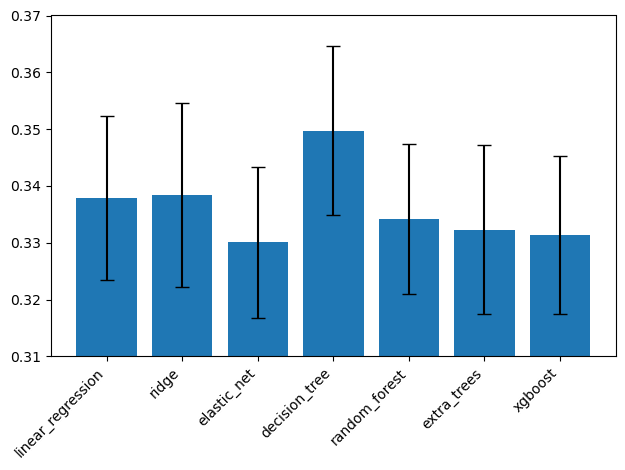

In [8]:
# get data for plotting
results_visualization = models_df[["name", "best_rmse", "rmse_std"]]

# plot results
plt.bar(
    x=range(len(results_visualization)),
    height=results_visualization["best_rmse"],
    yerr=results_visualization["rmse_std"],
    capsize=5,
    tick_label=results_visualization["name"]
)

# set y-axis range
plt.ylim(0.31, 0.37) 

# rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# adjust layout to prevent label cutoff
plt.tight_layout()

### Choose final model based on CV results and practical considerations

All model's performance is similar. 
It's actually really close.
Elastic Nets have a slight edge here.
This may be due to more regularization, which is good for small data sets.

The three best performing models are in this order:
Elastic Net, XGBoost and Extra Trees.

A general rule of thumb is that you can justify using a worse performing model
if the difference is less than 5%, and the worse performing model yields other
benefits.

Below, I calculate the absolute and relative differences between the RMSEs
between the three best models briefly.

In [9]:
# compare the difference in performance between the best performing models
# Extra Trees, XGBoost and Elastic Nets

# get performance as objects
rmse_extra_trees = float(models_df["best_rmse"][models_df["name"] == "extra_trees"].iloc[0])
rmse_xgboost = float(models_df["best_rmse"][models_df["name"] == "xgboost"].iloc[0])
rmse_elastic_net = float(models_df["best_rmse"][models_df["name"] == "elastic_net"].iloc[0])


# compare Extra Trees and XGBoost
calculate_differences_rmse(
    "Extra Trees",
    "XGBoost",
    rmse_extra_trees,
    rmse_xgboost
)

# compare Extra Trees and Elastic Net
calculate_differences_rmse(
    "Extra Trees",
    "Elastic Net",
    rmse_extra_trees,
    rmse_elastic_net
)

# compare XGBoost and Elastic Net
calculate_differences_rmse(
    "XGBoost",
    "Elastic Net",
    rmse_xgboost,
    rmse_elastic_net
)

Model 1: Extra Trees - Model 2: XGBoost
Absolute difference: 0.001
Percentage difference: 0.3009%


Model 1: Extra Trees - Model 2: Elastic Net
Absolute difference: 0.0022
Percentage difference: 0.6621%


Model 1: XGBoost - Model 2: Elastic Net
Absolute difference: 0.0012
Percentage difference: 0.3622%




In all cases, the difference in RMSE, which is our measure of performance, is
less than 5%.
To be more precise, in all cases, the difference is even less than 1%.

This means that choosing any of the three models Elastic Net, Extra Trees and
XGBoost is justified, because their performance is close to equal.

### Things to consider for selecting a model

After pre-selecting based on performance metrics (such as RMSE in this case),
these are some of the things to consider:

- If difference in RMSE is small, prefer simpler models
- Elastic net is best regarding here RMSE, but I want feature importance to find
out which features have greatest influence on sleep quality. 
Trees are better for this.
Using the feature importance to gain insight in this is a large part of what
motivated me to choose this as my project in the first place.
- If the models were larger, their prediction / inference speed would become a
factor to consider, but all these are pretty tiny, so I can ignore it.
- It's also possible to stack models as ensemble using StackingRegressor. That
way it would be possible to use Extra Trees for feature importance and use a
stacked model ensemble of Extra Trees and Elastic Nets for prediction.

### Applying this to my case

- Extra Trees and XGBoost perform almost equally.
On average, Extra Trees has a slightly larger RMSE,
but a larger standard deviation.
The difference in RMSE is less than 5% (rule of thumb threshold), and even less
than 1%.
- Extra Trees is generally less complex than XGBoost
- Extra Trees is less prone to overfitting
- Extra Trees tends to be more reliable and stable regarding feature importance
    - Averages across many independent trees
    - Less prone to bias compared to boosting methods
    - More consistent across different runs due to randomized nature
- XGBoost's feature importance may be somewhat less reliable under certain
circumstances
    - More sensitive to parameter tuning
    - Sometimes biased towards continuous features or high cardinality
    categorical features
    - Less stable across different runs due to the sequential nature of boosting
- I want to select the simplest solution, at equal performance.
Building a stacked ensemble would make things unnecessarily complicated, so I
will not do that.

### Conclusion

**I choose `Extra Trees`** to be my final model.
It is most likely the best option for my specific use case.
Even though, the other two options would likely also have been viable 
approaches.

The following parameters were identified as the best performing ones:
```
    {'max_depth': 3,
    'max_features': 'sqrt',
    'min_samples_leaf': 4,
    'min_samples_split': 10,
    'n_estimators': 50}
```

- While its RMSE is slightly larger than that of Elastic Nets, and XBGoost,
the differences are less than 1%, so that's totally reasonable.
- It allows for easily accessing feature importance. While Elastic Nets also
allow for interpretations, determining the feature importance is just superior
in tree based models. In Extra Trees, the feature importance is more reliable
than in XGBoost.
- Extra Trees is a simpler algorithm than XGBoost, so it's preferrable if
performance is equal. It is also simpler than a stacked ensemble.

## Train Final Model and Evaluate it on the Test Set

Now that an algorithm and hyperparameters were selected using cross-validation,
a final model needs to be trained according to this using the entire
train data set.

Subsequently, its final performance needs to be evaluated using the held-out
test set. This must only happen once at the very end after hyperparameter
tuning and model selection to:

- Prevent test set leakage
- Avoid unconscious bias in model selection
- More honest evaluation of final model
- Protection against overfitting to test set

### Train Final Model


In [10]:
# initialize final model
final_model = ExtraTreesRegressor(
    max_depth=3,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    n_estimators=100,
    random_state=1337,
    n_jobs=-1
)

# have a look at it to double check
final_model

ExtraTreesRegressor(max_depth=3, max_features='sqrt', min_samples_leaf=4,
                    min_samples_split=10, n_jobs=-1, random_state=1337)

In [11]:
# fit the model on all training data
final_model.fit(X_train, y_train.squeeze())

ExtraTreesRegressor(max_depth=3, max_features='sqrt', min_samples_leaf=4,
                    min_samples_split=10, n_jobs=-1, random_state=1337)

### Evaluate Final Model on Test Set

In [12]:
# get predictions of the model on the test set
y_pred = final_model.predict(X_test)

# calculate RMSE of final model using test set and predictions
test_rmse = root_mean_squared_error(y_test, y_pred)

# print results
print(f"RMSE on test set: {test_rmse:.4f}")
print(f"RMSE during cross validation: {rmse_extra_trees:.4f}")

RMSE on test set: 0.3297
RMSE during cross validation: 0.3323


#### Interpretation of Test Set Evaluation

It is actually slightly better on the test set.

However, an RMSE of 0.3297 means that, on average, the predictions deviate by 
0.3297
units from the true values.
Here, I scaled all the labels to an interval between 0 and 1.
This allows for some interpretation.
The error is quite substantial, and the model is not very accurate.
On average, it is about 32.97% off.
For convenience, I will round that to 33%, which is about a third.
One third of the full range is quite bad.

However, as seen during hyperparameter tuning, all the other models also have a
comparative performance, and no set of hyperparameters was able to improve that.

Now, why may that be the case?
I think it is most likely a combination of three factors.
The first one is the size of the data set. It has no more than 500 examples.
The second one is that I removed multiple features, which may would
have been helpful under regular circumstances, to facilitate meaningful
deployment as a service.
Finally, it is a synthetic data set, and the distributions didn't look too
convincing.

So, all in all, the model is not overwhelming, but it is important to consider
that it was trained on tiny data.
I really fell in love with the idea of building a tool for sleep quality
prediction and investigating the influence of certain variables.
I still think the idea is cool!
However, the data was quite questionable from the beginning, and for the next
project, I will have to find a larger data set
Also I am still a learner, and I need to improve much, much more to make the
best out even data like this.

Finally, the quality of sleep often varies.
We all know that from our own lives.
Perhaps being a third off is not extremely bad considering this.
While the prediciton is far from exact, it may be able to give a first idea of
if your sleep will be good, average or bad.

### Feature Importance

Todo: Take a look at feature importance here.


In [13]:
# get feature importance
importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
})

# sort by importance
importances = importances.sort_values('importance', ascending=False)

# show feature importances
importances


,feature,importance
0,age,0.158771
2,caffeine_intake,0.122926
3,gender=female,0.107997
4,gender=male,0.105995
13,wakeup_time,0.083388
8,study_hours,0.079412
6,physical_activity,0.079065
1,bedtime,0.073402
12,university_year=4th_Year,0.040607
11,university_year=3rd_Year,0.038301


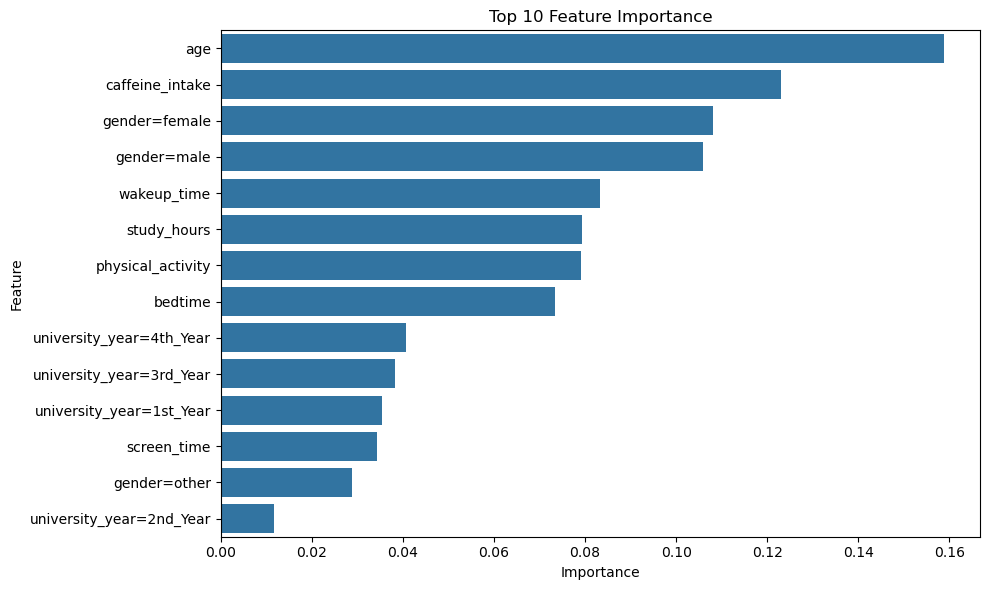

In [14]:
# plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importances, x='importance', y='feature')
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()

Interestingly, this is pretty different from what the initial estimation of
feature importance based on mutual information score (MIS) and
Pearsson Correlation (PC)
caused me to expect.

For me personally, based on my previous expectations, there are some surprises,
but also some expected outcomes.

First of all, no feature totally dominates all others, and all are at rather low values.

In MIS, age and caffeine intake were two of the features with the lowes values.
In PC, they were the two values with the largest predicted influence.
I would also have expected caffeine intake to be very important here.
Age being important to the model is more interesting, though, because the
variables total range is just from 18 to 25.
At closer inspection, it is trimodal.
While at first glance it looks rather normally distributed, there are some wide
gaps in between three groups of data.
Perhaps, this causes a tree based model to be able to make effective splits.
Actually, the same is true for caffeine intake.
There are some gaps in the distribution.
Maybe the fact these two are among the most important features is due to this.

Another surprising thing is that bedtime is comparatively low in this list,
because it was comparatively high in both MIS and PC.

## Training a Model on the Integrated Data Set

The same will be done for the integrated data as for the main data.

In [15]:
# refresh parameter grid
models_df_integrated = models_df[["name", "model", "param_grid"]]

# partial function to pass data to the grid search function
train_with_data_integrated = partial(
    train_model_with_gridsearch,
    X_train=X_train_integrated,
    y_train=y_train_integrated
)

# apply grid search to each model
results_integrated = models_df_integrated.apply(train_with_data_integrated, axis=1)

# add results to models_df
models_df_integrated = pd.concat([models_df_integrated, results_integrated], axis=1)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


/Users/fakrueg/miniforge3/envs/RestAI/lib/python3.13/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 5 folds for each of 540 candidates, totalling 2700 fits
Fitting 5 folds for each of 6480 candidates, totalling 32400 fits


/Users/fakrueg/miniforge3/envs/RestAI/lib/python3.13/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [16]:
# print results: Model, best parameters and corresponding RMSE
for _, row in models_df_integrated.iterrows():
    print(f"\nModel: {row['name']}")
    print(f"Best parameters: {row['best_params']}")
    print(f"Best RMSE: {row['best_rmse']} ± {row['rmse_std']}")


Model: linear_regression
Best parameters: {'fit_intercept': False, 'positive': False}
Best RMSE: 0.2747 ± 0.0104

Model: ridge
Best parameters: {'alpha': 1.0, 'fit_intercept': True}
Best RMSE: 0.2734 ± 0.0111

Model: elastic_net
Best parameters: {'alpha': 0.001, 'fit_intercept': True, 'l1_ratio': 0.5}
Best RMSE: 0.2732 ± 0.0103

Model: decision_tree
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 20}
Best RMSE: 0.2121 ± 0.0109

Model: random_forest
Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best RMSE: 0.1878 ± 0.0086

Model: extra_trees
Best parameters: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best RMSE: 0.1873 ± 0.0081

Model: xgboost
Best parameters: {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'n_estim

In [17]:
# show results in data frame format
models_df_integrated

,name,model,param_grid,best_params,best_rmse,rmse_std,best_model
0,linear_regression,LinearRegression(),"{'fit_intercept': [True, False], 'positive': [...","{'fit_intercept': False, 'positive': False}",0.2747,0.0104,LinearRegression(fit_intercept=False)
1,ridge,Ridge(random_state=1337),"{'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0...","{'alpha': 1.0, 'fit_intercept': True}",0.2734,0.0111,Ridge(random_state=1337)
2,elastic_net,ElasticNet(random_state=1337),"{'alpha': [0.001, 0.01, 0.1, 1.0], 'l1_ratio':...","{'alpha': 0.001, 'fit_intercept': True, 'l1_ra...",0.2732,0.0103,"ElasticNet(alpha=0.001, random_state=1337)"
3,decision_tree,DecisionTreeRegressor(random_state=1337),"{'max_depth': [3, 5, 7, 10, None], 'min_sample...","{'max_depth': 10, 'max_features': 'sqrt', 'min...",0.2121,0.0109,"DecisionTreeRegressor(max_depth=10, max_featur..."
4,random_forest,"RandomForestRegressor(n_jobs=-1, random_state=...","{'n_estimators': [50, 100, 200, 300], 'max_dep...","{'bootstrap': True, 'max_depth': None, 'max_fe...",0.1878,0.0086,"(DecisionTreeRegressor(max_features='log2', mi..."
5,extra_trees,"ExtraTreesRegressor(n_jobs=-1, random_state=1337)","{'n_estimators': [50, 100, 200, 300], 'max_dep...","{'max_depth': 10, 'max_features': None, 'min_s...",0.1873,0.0081,"(ExtraTreeRegressor(max_depth=10, max_features..."
6,xgboost,"XGBRegressor(base_score=None, booster=None, ca...","{'n_estimators': [50, 100, 200, 300], 'max_dep...","{'colsample_bytree': 0.6, 'gamma': 0.1, 'learn...",0.1918,0.0108,"XGBRegressor(base_score=None, booster=None, ca..."


Interestingly, the model's performances are rather different this time.
Extra Trees is still the best one, but Elastic Net is not among the best ones
anymore. In general, the RMSE is lower than before, while the label's range
did not change.

Apparently, adding more data allowed the model to fit the data set more
accurately, which is expected.

However, in the EDA of the `01-data_preparation.ipynb` notebook, I saw that the
distribution of the label is highly skewed.
Most labels were very low, representing very bad sleep.
I am not entirely sure what exactly introduced this, but it was present.
one of the additional data sets must have contained weird values for the label.

I can get the predictions for this model and inspect them.
If the model just predicts very bad sleep for the majority of cases, it may
have a good fit on the data, but it is still useless.
It wouldn't be the model's fault, however.
There is no way to outtrain bad data.
Sh\*t in - sh\*it out.

This data set has tons of variables, and I don't want the users to have to enter
them all.
XGBoost models are able to handle missing values.
I will choose XGBoost as final model this time, because of this capability of
handling missing values, and test it on its test set as well as the previous
test set including the main data only.

In [18]:
# initialize model with best parameters
xgb_model = xgb.XGBRegressor(
    colsample_bytree=0.6,
    gamma=0.1,
    learning_rate=0.05,
    max_depth=6,
    min_child_weight=1,
    n_estimators=200,
    subsample=0.8,
    random_state=1337,  # for reproducibility
    n_jobs=-1  # use all cores
)

# fit the model
xgb_model.fit(
    X_train_integrated,
    y_train_integrated.squeeze(),
    # optional: early stopping using validation set
    # eval_set=[(X_val, y_val)],
    # early_stopping_rounds=10,
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=-1,
             num_parallel_tree=None, random_state=1337, ...)

In [19]:
# test model using test set
y_pred_integrated = xgb_model.predict(X_test_integrated)

# calculate RMSE
rmse_integrated = root_mean_squared_error(y_test_integrated, y_pred_integrated)

# print results
print(f"RMSE on integrated test set: {rmse_integrated:.4f}")

RMSE on integrated test set: 0.1927


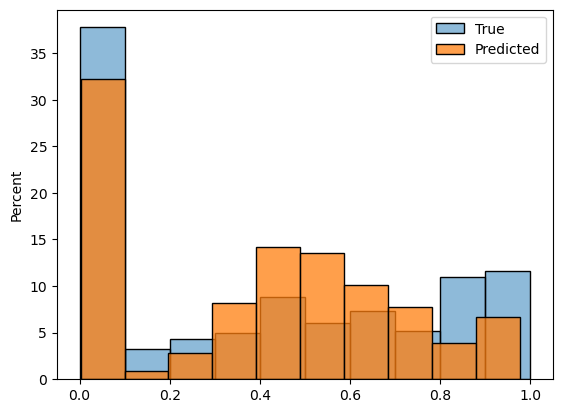

In [20]:
# plot true and predicted labels' distribution in percent or fraction or total
sns.histplot(y_test_integrated, label="True", stat="percent")
sns.histplot(y_pred_integrated, label="Predicted", stat="percent")
plt.legend()
plt.show()


Okay, so interestingly in about a third of cases, the model telly you you sleep
is going to be abysmal.
Otherwise chances are good for average.

Unfortunately, this model is not usable.
The entire idea for data set integration was an experiment.
It was never guaranteed it would yield improved performance or a better model.
Finally, it turned out *the model* itself or rather its predictions actually
became "better" - most likely because more data was used.
Unfortunately, however, the data set wasn't integrated well, apparently, and the
model now is just pretty good at predictiting this questionable data it is based
on.
Thirty percent chance for absolutely terrible sleep is not realistic in my
opinion.

**My final choice of model is the first Extra Trees model trained on the main**
**data only.**

The training of that respective model will be exported to a script, and the
trained model resulting from that will be deployed.